In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io
from scipy.signal import find_peaks,find_peaks_cwt,peak_prominences,peak_widths

`data.npz` contains data products from a 5G base-station.

* XYZ: (N_antenna, 2) cartesian antenna positions
* S: (N_slot, N_antenna, N_antenna) covariance matrices per time slot.
* T_slot: duration of a slot [s]
* lambda_: channel wavelength [m]
* src_model: (N_tx, 2) unit directions of transmitters in the cell area.

Communication systems process data at high throughput. As such it is difficult to capture long antenna traces.
Since throughput assessment via beamforming only requires solving positional inferance problems, we instead provide the (much) smaller covariance estimates between antennas per short time interval (1 [ms]).

In [2]:
path='data/data_1.npz'
df=np.load(path)
xyz=df['XYZ']
S=df['S']
T_slot=df['T_slot']
lambda_=df['lambda_']
src_model=df['src_model']

In [3]:
xyz.shape,S.shape,T_slot,lambda_,src_model.shape

((19, 2), (10000, 19, 19), array(0.001), array(0.33684546), (121, 2))

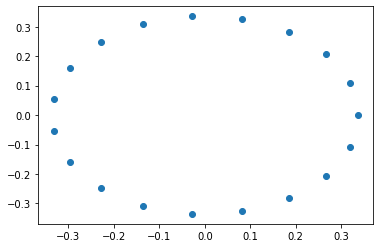

In [4]:
plt.scatter(xyz[:,0],xyz[:,1])
plt.show()

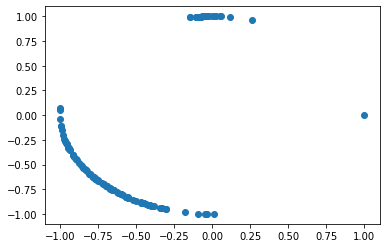

In [5]:
plt.scatter(src_model[:,0],src_model[:,1])
plt.show()

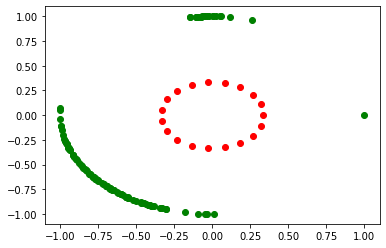

In [6]:
plt.plot(xyz[:,0],xyz[:,1],'ro',src_model[:,0],src_model[:,1], 'go')
plt.show()

In [7]:
signal=S[0]
signal.shape

(19, 19)

In [8]:
thetas=np.arange(0,360,0.1)
a=np.exp(-1j*2*np.pi/lambda_*(xyz@[np.cos(thetas*np.pi/180),np.sin(thetas*np.pi/180)])).reshape(xyz.shape[0],-1)
a.shape,thetas.shape

((19, 3600), (3600,))

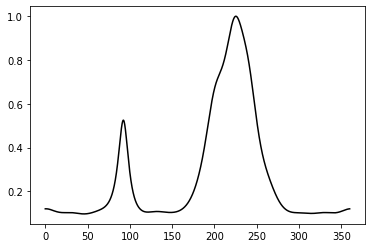

In [9]:
P=np.zeros(thetas.shape)
for i in range(len(thetas)):
    P[i]=1/abs(np.dot(a[:,i].conj().T,np.dot(np.linalg.inv(signal),a[:,i])))
P=P/max(P)
plt.plot(thetas,P,'-k')
plt.show()

In [10]:
peaks,_=find_peaks(P,height=np.mean(P))
widths=peak_widths(P,peaks)[0]
prominences=peak_prominences(P,peaks)[0]
peaks,widths,prominences

(array([ 923, 2253]),
 array([140.29983621, 548.32343327]),
 array([0.42159888, 0.90066806]))

In [11]:
def doa(signal,xyz):
    thetas=np.arange(0,360,0.1)
    a=np.exp(-1j*2*np.pi/lambda_*(xyz@[np.cos(thetas*np.pi/180),np.sin(thetas*np.pi/180)])).reshape(xyz.shape[0],-1)
    P=np.zeros(thetas.shape)
    for i in range(len(thetas)):
        P[i]=1/abs(np.dot(a[:,i].conj().T,np.dot(np.linalg.inv(signal),a[:,i])))
    peaks,_=find_peaks(P,height=np.mean(P))
    widths=peak_widths(P,peaks)[0]/len(P)*360
    prominences=peak_prominences(P,peaks)[0]
            
    return thetas[peaks],widths,prominences
    

In [12]:
directions=[]
Theta=[]
weights=[]
for i in range(10):
    peaks,widths,prominences=doa(S[i*1000],xyz)
    directions.append(peaks)
    Theta.append(widths)
    weights.append(prominences)
    print(i,peaks,widths,prominences)

0 [ 92.3 225.3] [14.02998362 54.83234333] [16.48567803 35.21860276]
1 [ 92.5 225.2] [14.15797437 53.07386444] [16.10449949 36.29604812]
2 [ 92.6 224.9] [14.19274214 55.24933313] [16.43343557 35.72546222]
3 [ 92.6 225.8] [13.64957074 53.94044789] [16.78187478 35.9560601 ]
4 [ 92.5 225.3] [13.86576787 53.72656254] [16.4298908 36.3476551]
5 [ 92.5 224.5] [14.56077345 54.75268846] [15.96362394 35.8264409 ]
6 [ 92.6 223.3] [14.34261796 54.5308881 ] [16.10678695 35.15512375]
7 [ 92.5 225.7] [14.13344783 54.41999462] [16.575069   34.42352578]
8 [ 92.3 225.5] [14.21799692 53.80128686] [16.5911957  36.21638061]
9 [ 92.5 224.8] [13.74055214 54.17510407] [17.24713211 36.2915202 ]


In [13]:
src=np.zeros((121,3))
src.shape

(121, 3)

In [14]:
src[:,:2]=src_model

In [15]:
for i in range(src.shape[0]):
    src[i,2]=np.arctan(src[i,1]/src[i,0])
    if src[i,0]<0:
        src[i,2]+=np.pi
    if src[i,2]<0:
        src[i,2]+=2*np.pi

In [16]:
io.savemat('data/data_1.mat', {'directions': directions,'xyz':xyz,'src_model':src,'weights':weights,'Theta':Theta,'S':[S[i*1000]for i in range(10)]})

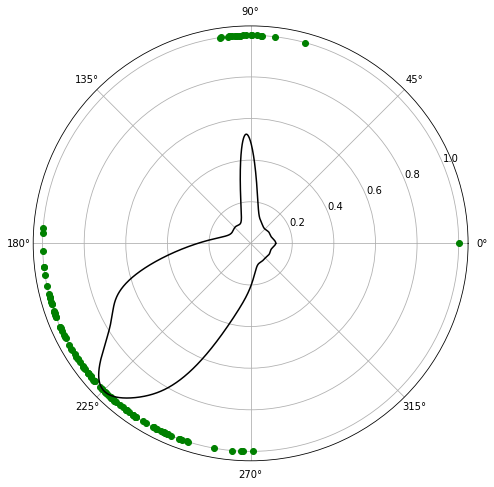

In [17]:
plt.figure(figsize=(8,8))
plt.polar()
plt.plot(src[:,2],np.ones(len(src)),'go',thetas*np.pi/180,P,'-k')
plt.savefig('doa_and_sources.png')
plt.show()

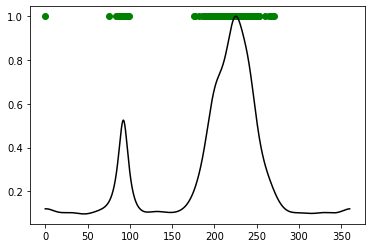

In [18]:
plt.plot(src[:,2]/np.pi*180,np.ones(len(src)),'go',thetas,P,'-k')
plt.show()

In [19]:
path='data/data_2.npz'
df=np.load(path)
xyz=df['XYZ']
S=df['S']
T_slot=df['T_slot']
lambda_=df['lambda_']
src_model=df['src_model']

In [20]:
xyz.shape,S.shape,T_slot,lambda_,src_model.shape

((15, 2), (10000, 15, 15), array(0.001), array(0.33684546), (121, 2))

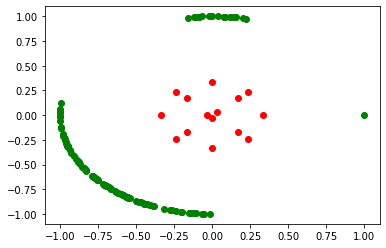

In [21]:
plt.plot(xyz[:,0],xyz[:,1],'ro',src_model[:,0],src_model[:,1], 'go')
plt.show()

In [23]:
directions=[]
Theta=[]
weights=[]
for i in range(10):
    peaks,widths,prominences=doa(S[i*1000],xyz)
    directions.append(peaks)
    Theta.append(widths)
    weights.append(prominences)
    print(i,peaks,widths,prominences)

0 [ 88.7 231.6] [20.50426162 83.06718354] [18.6966719  32.66385462]
1 [ 88.6 231.8] [20.46670677 82.79182693] [18.72830294 32.60259551]
2 [ 88.4 231.8] [20.30412218 84.30223223] [18.93674054 32.2162094 ]
3 [ 88.2 230.6] [20.2532128  83.15493439] [18.99272129 32.94584876]
4 [ 88.7 190.3 231.6] [20.507       5.77354996 84.95200487] [18.75297784  0.43389164 32.23311575]
5 [ 88.5 232.7] [20.31847158 84.66413003] [18.1807945  31.17909471]
6 [ 88.6 231.6] [20.19081818 83.86557549] [18.45338898 32.32590739]
7 [ 88.6 231. ] [20.31322069 83.35805755] [18.89708781 32.66190119]
8 [ 88.5 191.5 231.7] [20.5119346   5.20870181 83.61106581] [18.70885351  0.21781574 33.32592053]
9 [ 88.5 192.  230.8] [19.92622938  8.40431302 84.44445527] [19.07926145  0.83498157 32.2396207 ]


In [24]:
src=np.zeros((121,3))
src[:,:2]=src_model
for i in range(src.shape[0]):
    src[i,2]=np.arctan(src[i,1]/src[i,0])
    if src[i,0]<0:
        src[i,2]+=np.pi
    if src[i,2]<0:
        src[i,2]+=2*np.pi
io.savemat('data/data_2.mat', {'directions': directions,'xyz':xyz,'src_model':src,'weights':weights,'Theta':Theta,'S':[S[i*1000]for i in range(10)]})

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
